# Preamble

In [347]:
#import packages

#%matplotlib widget

from diversity import Metacommunity
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
import random
from collections import Counter
from joblib import Parallel, delayed
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.feature import hog
from functools import partial
from os.path import expanduser
from PIL import Image
from scipy.stats import linregress, norm
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import median as median_filter
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from statistics import NormalDist

<div class="alert-danger">
Warning: do not change anything in this notebook until after the bad images have been thrown away (near the end of section IV). Otherwise, the final set of 100 pairs of images will also change, and won't match the 100 pairs of Liza.
</div>

# I. Loading images and reshuffling them

In [302]:
#Path to folder
indir = "/Volumes/Repo19/ArnaoutLab/Diversity_python_package_paper_2023/"
path = indir + "Pathology_slides_examples/pathmnist.npz"
outdir = expanduser("~") + "/ArnaoutLab Dropbox/Ramy Arnaout/Papers_2023/Diversity_python_package_paper_2023/"

In [3]:
data = np.load(path)

In [4]:
data.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [5]:
images = data['train_images']

In [6]:
Counter(list(data['train_labels'].flatten()))

Counter({0: 9366,
         4: 8006,
         7: 9401,
         5: 12182,
         8: 12885,
         3: 10401,
         2: 10360,
         1: 9509,
         6: 7886})

In [7]:
#Total number of images
n=len(images)
n

89996

In [8]:
#See the size of each image and if it's a color image
images[0].shape

(28, 28, 3)

In [9]:
#Randomize the order of images in place
order = list(range(n))

def myfunction():
  return 0.2
    
random.shuffle(order, myfunction)

/var/folders/28/cyrygc490j9g02n4k8ncygzm0000gn/T/ipykernel_15373/894117780.py:7: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(order, myfunction)


In [10]:
shuffled_imgs = images[order]

In [11]:
# Visualize the shuffled images
fig, axs = plt.subplots(ncols=10, nrows=5, figsize=(13,5))
for i in range(10):
   axs[0][i].imshow(shuffled_imgs[i])
for i in range(10):
   axs[1][i].imshow(shuffled_imgs[10+i])
for i in range(10):
   axs[2][i].imshow(shuffled_imgs[20+i])
for i in range(10):
   axs[3][i].imshow(shuffled_imgs[30+i])
for i in range(10):
   axs[4][i].imshow(shuffled_imgs[40+i])
plt.show()

# II. Preprocessing by thresholding the hue (but not yet the lightness!)

In [12]:
hues_raw = np.array([rgb2hsv(img)[:,:,0] for img in shuffled_imgs])
#saturations = np.array([rgb2hsv(img)[:,:,1] for img in shuffled_imgs])
#values = np.array([rgb2hsv(img)[:,:,2] for img in shuffled_imgs])

In [13]:
hues_raw.shape

(89996, 28, 28)

In [14]:
reds = np.array([img[:,:,0] for img in shuffled_imgs])
greens = np.array([img[:,:,1] for img in shuffled_imgs])
blues = np.array([img[:,:,2] for img in shuffled_imgs])

In [15]:
reds.shape

(89996, 28, 28)

In [16]:
#Computing the lightnesses of all the images. 

lightnesses_raw = (1/2)*(1/255)*(np.maximum(np.maximum(reds, greens), blues).astype(float) + np.minimum(np.minimum(reds, greens), blues).astype(float))

In [17]:
lightnesses_raw.shape

(89996, 28, 28)

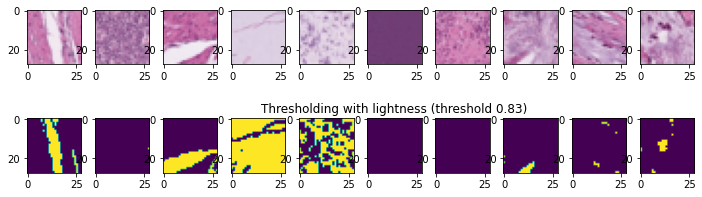

In [18]:
#Visualizing the threshold
def thresh(i):
    return lightnesses_raw[i] > 0.83

mask = np.array([thresh(i) for i in range(n)])
    
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(12,3))
plt.subplots_adjust(hspace=1)

for i in range(10):
    axs[0][i].imshow(shuffled_imgs[i])
    axs[1][i].imshow(thresh(i))

axs[1][5].set_title("Thresholding with lightness (threshold 0.83)")

plt.show()

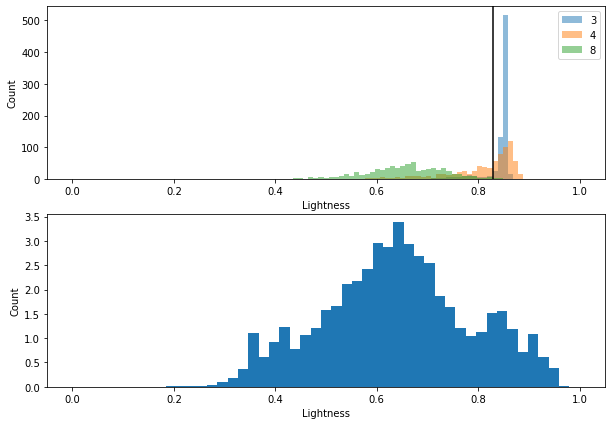

(0.23529411764705882, 0.9549019607843137)

In [19]:
bins = np.linspace(0,1,100)

fig, axs = plt.subplots(2,1,figsize=(10,7))

axs[0].hist(lightnesses_raw[3].flatten(), label='3', alpha=0.5, bins=bins)
axs[0].hist(lightnesses_raw[4].flatten(), label='4', alpha=0.5, bins=bins)
axs[0].hist(lightnesses_raw[8].flatten(), label='8', alpha=0.5, bins=bins)
axs[0].axvline(0.83, color="black")
axs[0].set_xlabel("Lightness")
axs[0].set_ylabel("Count")
axs[0].legend()

axs[1].hist(lightnesses_raw.flatten(), bins=np.linspace(0,1,50), density=True)
axs[1].set_xlabel("Lightness")
axs[1].set_ylabel("Count")
plt.show()

np.percentile(lightnesses_raw, 0.1), np.percentile(lightnesses_raw, 99.9)

In [20]:
#Thresholding the hues.
hues = np.maximum(mask, hues_raw)

In [21]:
hues.shape

(89996, 28, 28)

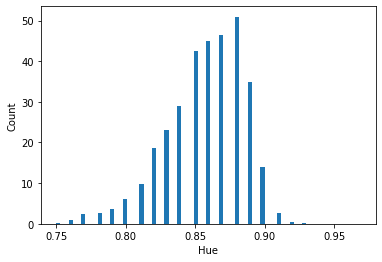

(0.7522875816993464, 1.0)

In [22]:
plt.figure()
plt.hist(np.round(hues.flatten(),2), bins=np.arange(0.75,0.97,0.003) , density=True)
plt.xlabel("Hue")
plt.ylabel("Count")
plt.show()
np.percentile(hues, 0.1), np.percentile(hues, 99.9)

# III. Computing the hues and lightness histograms, for various superpixel sizes

In [23]:
#Hue histogram for the original image, with normalization
hue_hists = np.array([np.histogram(hues[i].ravel(), bins=np.linspace(0.75,1, 29))[0] for i in range(n)])
hue_hists =np.array([hist/np.sum(hist) for hist in hue_hists])

In [24]:
hue_hists.shape

(89996, 28)

In [25]:
#Hue channels after grouping pixels
hues_2 = hues.reshape(n, 14, 2, 14, 2).mean(axis=(2,4))
hues_4 = hues.reshape(n, 7, 4, 7, 4).mean(axis=(2,4))
hues_7 = hues.reshape(n, 4, 7, 4, 7).mean(axis=(2,4))
hues_14 = hues.reshape(n, 2, 14, 2, 14).mean(axis=(2,4))
hues_28 = hues.reshape(n, 1, 28, 1, 28).mean(axis=(2,4))

In [26]:
#Hue histograms for all the superpixel sizes

hue_hists_2 = np.array([np.histogram(hues_2[i].ravel(), bins=np.linspace(0.75, 1, 15))[0] for i in range(n)])

hue_hists_4 = np.array([np.histogram(hues_4[i].ravel(), bins=np.linspace(0.75, 1, 8))[0] for i in range(n)])

hue_hists_7 = np.array([np.histogram(hues_7[i].ravel(), bins=np.linspace(0.75, 1, 5))[0] for i in range(n)])

hue_hists_14 = np.array([np.histogram(hues_14[i].ravel(), bins=np.linspace(0.75, 1, 3))[0] for i in range(n)])

hue_hists_28 = np.array([np.histogram(hues_28[i].ravel(), bins=np.linspace(0.75, 1, 2))[0] for i in range(n)])

In [27]:
#Lightness histogram

lightness_raw_hists = np.array([np.histogram(lightnesses_raw[i].ravel(), bins=np.linspace(0.2, 1, 29))[0] for i in range(n)])
lightness_raw_hists =np.array([hist/np.sum(hist) for hist in lightness_raw_hists])

In [28]:
lightness_raw_hists.shape

(89996, 28)

# IV. More preprocessing to eliminate bad images; normalizing the hue histograms

In [29]:
empty_hists = []

for i in range(n):
    if (np.sum(hue_hists_2[i]) == 0) or (np.sum(hue_hists_4[i]) == 0) or (np.sum(hue_hists_7[i]) == 0) or (np.sum(hue_hists_14[i]) == 0) or (np.sum(hue_hists_28[i]) == 0):
        empty_hists.append(i)

In [30]:
len(empty_hists)

30

In [31]:
uniform_dark_purple = []

for i in range(n):
    if (True in (hue_hists[i] > 0.5)) and np.sum(np.minimum(hue_hists[i], hue_hists[5])) > 0.4:
        uniform_dark_purple.append(i)

In [32]:
len(uniform_dark_purple)

1382

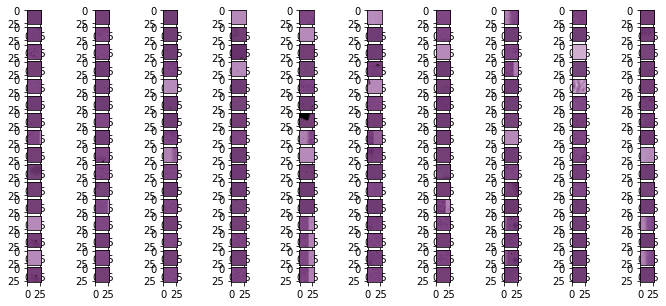

In [33]:
fig, axs = plt.subplots(16, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[uniform_dark_purple[i]])
    axs[1][i].imshow(shuffled_imgs[uniform_dark_purple[10+i]])
    axs[2][i].imshow(shuffled_imgs[uniform_dark_purple[20+i]])
    axs[3][i].imshow(shuffled_imgs[uniform_dark_purple[30+i]])
    axs[4][i].imshow(shuffled_imgs[uniform_dark_purple[40+i]])
    axs[5][i].imshow(shuffled_imgs[uniform_dark_purple[50+i]])
    axs[6][i].imshow(shuffled_imgs[uniform_dark_purple[60+i]])
    axs[7][i].imshow(shuffled_imgs[uniform_dark_purple[70+i]])
    axs[8][i].imshow(shuffled_imgs[uniform_dark_purple[80+i]])
    axs[9][i].imshow(shuffled_imgs[uniform_dark_purple[90+i]])
    axs[10][i].imshow(shuffled_imgs[uniform_dark_purple[100+i]])
    axs[11][i].imshow(shuffled_imgs[uniform_dark_purple[110+i]])
    axs[12][i].imshow(shuffled_imgs[uniform_dark_purple[120+i]])
    axs[13][i].imshow(shuffled_imgs[uniform_dark_purple[130+i]])
    axs[14][i].imshow(shuffled_imgs[uniform_dark_purple[120+i]])
    axs[15][i].imshow(shuffled_imgs[uniform_dark_purple[130+i]])
plt.show()

In [34]:
dark = []

for i in range(n):
    if np.max(lightnesses_raw[i]) < 0.5:
        dark.append(i)

In [35]:
len(dark)

5264

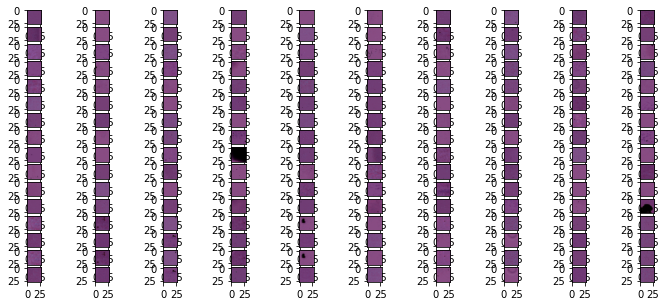

In [36]:
fig, axs = plt.subplots(16, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[dark[i]])
    axs[1][i].imshow(shuffled_imgs[dark[10+i]])
    axs[2][i].imshow(shuffled_imgs[dark[20+i]])
    axs[3][i].imshow(shuffled_imgs[dark[30+i]])
    axs[4][i].imshow(shuffled_imgs[dark[40+i]])
    axs[5][i].imshow(shuffled_imgs[dark[50+i]])
    axs[6][i].imshow(shuffled_imgs[dark[60+i]])
    axs[7][i].imshow(shuffled_imgs[dark[70+i]])
    axs[8][i].imshow(shuffled_imgs[dark[80+i]])
    axs[9][i].imshow(shuffled_imgs[dark[90+i]])
    axs[10][i].imshow(shuffled_imgs[dark[100+i]])
    axs[11][i].imshow(shuffled_imgs[dark[110+i]])
    axs[12][i].imshow(shuffled_imgs[dark[120+i]])
    axs[13][i].imshow(shuffled_imgs[dark[130+i]])
    axs[14][i].imshow(shuffled_imgs[dark[120+i]])
    axs[15][i].imshow(shuffled_imgs[dark[130+i]])
plt.show()

In [37]:
uniform_light_pink = []

for i in range(n):
    if np.sum(np.minimum(hue_hists[i], hue_hists[25])) > 0.9:
        uniform_light_pink.append(i)

In [38]:
len(uniform_light_pink)

1489

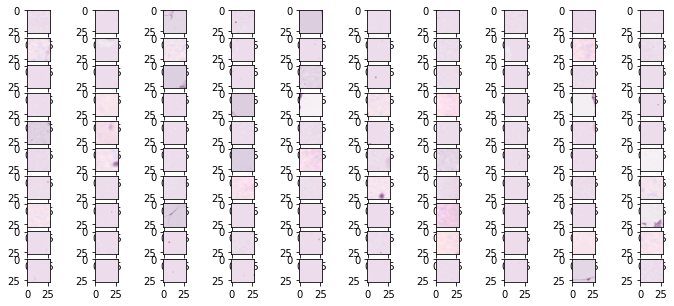

In [39]:
fig, axs = plt.subplots(10, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[uniform_light_pink[i]])
    axs[1][i].imshow(shuffled_imgs[uniform_light_pink[10+i]])
    axs[2][i].imshow(shuffled_imgs[uniform_light_pink[20+i]])
    axs[3][i].imshow(shuffled_imgs[uniform_light_pink[30+i]])
    axs[4][i].imshow(shuffled_imgs[uniform_light_pink[40+i]])
    axs[5][i].imshow(shuffled_imgs[uniform_light_pink[50+i]])
    axs[6][i].imshow(shuffled_imgs[uniform_light_pink[60+i]])
    axs[7][i].imshow(shuffled_imgs[uniform_light_pink[70+i]])
    axs[8][i].imshow(shuffled_imgs[uniform_light_pink[80+i]])
    axs[9][i].imshow(shuffled_imgs[uniform_light_pink[90+i]])

plt.show()

In [40]:
other_blues = []

for i in range(n):
    if np.sum(np.minimum(hue_hists[i], hue_hists[1985])) > 0.5 and np.sum(hue_hists[i][10:20]) == 0:
        other_blues.append(i)
    elif np.sum(np.minimum(hue_hists[i], hue_hists[1644])) > 0.5 and np.sum(hue_hists[i][10:20]) == 0:
        other_blues.append(i)

In [41]:
len(other_blues)

218

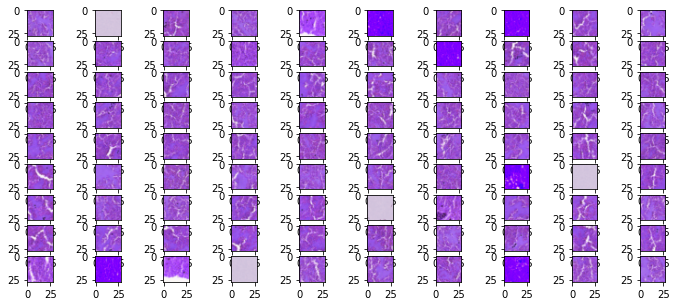

In [42]:
fig, axs = plt.subplots(9, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[other_blues[i]])
    axs[1][i].imshow(shuffled_imgs[other_blues[10+i]])
    axs[2][i].imshow(shuffled_imgs[other_blues[20+i]])
    axs[3][i].imshow(shuffled_imgs[other_blues[30+i]])
    axs[4][i].imshow(shuffled_imgs[other_blues[40+i]])
    axs[5][i].imshow(shuffled_imgs[other_blues[50+i]])
    axs[6][i].imshow(shuffled_imgs[other_blues[60+i]])
    axs[7][i].imshow(shuffled_imgs[other_blues[70+i]])
    axs[8][i].imshow(shuffled_imgs[other_blues[80+i]])
plt.show()

In [43]:
bad = list(set(empty_hists + uniform_dark_purple + dark + uniform_light_pink + other_blues))

In [44]:
len(bad)

7298

<div class="alert-danger">
Attention ! Some variables have been redefined in the following cell.
</div>

In [45]:
#Redefining several arrays of images and hues again to remove bad images.

shuffled_imgs = np.array([shuffled_imgs[i] for i in range(n) if i not in bad])
hues_raw = np.array([hues_raw[i] for i in range(n) if i not in bad])
lightnesses_raw = np.array([lightnesses_raw[i] for i in range(n) if i not in bad])

n = n - len(bad)

In [46]:
#Redoing the thresholding with a slightly lower threshold

new_mask = np.array([(lightnesses_raw[i] > 0.81) for i in range(n)])
hues = np.maximum(new_mask, hues_raw)
lightnesses = np.maximum(new_mask, lightnesses_raw)

In [47]:
print(n, hues.shape, lightnesses.shape)

82698 (82698, 28, 28) (82698, 28, 28)


In [48]:
#Remaking the hue histograms and normalizing them, now without the bad images.

hue_hists = np.array([np.histogram(hues[i].ravel(), bins=np.linspace(0.75, 1, 29))[0] for i in range(n)])
hue_hists = np.array([hist/np.sum(hist) for hist in hue_hists])

In [49]:
#Remaking the lightness histograms and normalizing them, now without the bad images.

lightness_hists = np.array([np.histogram(lightnesses[i].ravel(), bins=np.linspace(0.2, 1, 29))[0] for i in range(n)])
lightness_hists = np.array([hist/np.sum(hist) for hist in lightness_hists])

In [50]:
print(len(hue_hists), len(lightness_hists))

82698 82698


In [51]:
print(hue_hists[0].shape, lightness_hists[0].shape)

(28,) (28,)


# Hue and lightness similarities

In [52]:
def hue_sim_func(hue_1, hue_2):
    hue_hist_1 = np.histogram(hue_1.ravel(), bins=np.linspace(0.75, 1, 29))[0] 
    hue_hist_2 = np.histogram(hue_2.ravel(), bins=np.linspace(0.75, 1, 29))[0]

    hue_hist_1 = hue_hist_1/np.sum(hue_hist_1)
    hue_hist_2 = hue_hist_2/np.sum(hue_hist_2)

    return np.sum(np.minimum(hue_hist_1, hue_hist_2))

In [53]:
def lightness_sim_func(lightness_1, lightness_2):
    lightness_hist_1 = np.histogram(lightness_1.ravel(), bins=np.linspace(0.2, 1, 29))[0] 
    lightness_hist_2 = np.histogram(lightness_2.ravel(), bins=np.linspace(0.2, 1, 29))[0]

    lightness_hist_1 = lightness_hist_1/np.sum(lightness_hist_1)
    lightness_hist_2 = lightness_hist_2/np.sum(lightness_hist_2)

    return np.sum(np.minimum(lightness_hist_1, lightness_hist_2))

# Texture

In [54]:
def list_of_neis(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c), (r,c-1), (r,c+1), (r+1,c), 
             (r-1,c-1), (r-1,c+1), (r+1,c-1), (r+1,c+1),
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (0,1), (1,0), 
                (1,1)
               ]
    elif (r == 0) and (c == n-1):
        neis = [
            (0,n-2), (1,n-2), 
                (1,n-1)
               ]
    elif (r == m-1) and (c == 0):
        neis = [
            (m-2, 0), (m-1,1),
               (m-2,1),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-1,n-2), (m-2,n-1),
               (m-2,n-2),
               ]
    elif (r==0):
        neis = [
            (0, c-1), (1,c), (0,c+1),
               (1,c-1), (1,c+1),
               ]
    elif (r==m-1):
        neis = [
            (m-1,c-1), (m-2,c), (m-1,c+1),
               (m-2,c-1), (m-2,c+1),
               ]
    elif (c==0):
        neis = [
            (r-1, 0), (r,1), (r+1,0),
                (r-1,1), (r+1,1),
               ]
    elif (c==n-1):
        neis = [
            (r-1,n-1), (r,n-2), (r+1,n-1),
               (r-1,n-2), (r+1,n-2),
               ]
    return neis



In [55]:
def list_of_horizontal_neis(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r,c-1), (r,c+1),
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (0,1),
               ]
    elif (r == 0) and (c == n-1):
        neis = [
            (0,n-2),
               ]
    elif (r == m-1) and (c == 0):
        neis = [
            (m-1,1),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-1,n-2),
               ]
    elif (r==0):
        neis = [
            (0, c-1), (0,c+1),
               ]
    elif (r==m-1):
        neis = [
            (m-1,c-1), (m-1,c+1),
               ]
    elif (c==0):
        neis = [
            (r,1), 
               ]
    elif (c==n-1):
        neis = [
            (r,n-2), 
               ]
    return neis

In [56]:
def list_of_vertical_neis(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c), (r+1,c), 
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (1,0), 
               ]
    elif (r == 0) and (c == n-1):
        neis = [
                (1,n-1),
               ]
    elif (r == m-1) and (c == 0):
        neis = [
            (m-2, 0),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-2,n-1),
               ]
    elif (r==0):
        neis = [
            (1,c), 
               ]
    elif (r==m-1):
        neis = [
             (m-2,c),
               ]
    elif (c==0):
        neis = [
            (r-1, 0), (r+1,0),
               ]
    elif (c==n-1):
        neis = [
            (r-1,n-1), (r+1,n-1),
               ]
    return neis

In [57]:
def list_of_diagonal_neis_1(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c-1), (r+1,c+1), 
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (1,1), 
               ]
    elif (r == 0) and (c == n-1):
        neis = [
               ]
    elif (r == m-1) and (c == 0):
        neis = [
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-2,n-2),
               ]
    elif (r==0):
        neis = [
            (1,c+1), 
               ]
    elif (r==m-1):
        neis = [
             (m-2,c-1),
               ]
    elif (c==0):
        neis = [
            (r+1,1),
               ]
    elif (c==n-1):
        neis = [
            (r-1,n-2)
               ]
    return neis

In [58]:
def list_of_diagonal_neis_2(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c+1), (r+1,c-1), 
            ]
    elif (r == 0) and (c == 0):
        neis = [
               ]
    elif (r == 0) and (c == n-1):
        neis = [
                (1,n-2),
               ]
    elif (r == m-1) and (c == 0):
        neis = [
                (m-2,1),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
               ]
    elif (r==0):
        neis = [
            (1,c-1), 
               ]
    elif (r==m-1):
        neis = [
             (m-2,c+1),
               ]
    elif (c==0):
        neis = [
            (r-1,1),
               ]
    elif (c==n-1):
        neis = [
            (r+1,n-2)
               ]
    return neis

In [59]:
def mottledness(img):
    gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(m):
        for c in range(n):
            neis = list_of_neis(r,c,m,n)
            diffs = [img[r,c] - img[nei] for nei in neis]
            max_abs_diff = np.max(np.absolute(np.array(diffs)))  # other options: np.median or np.mean
            gradients.append(max_abs_diff)

    gradients = np.array(gradients)
    
    return (np.sum(gradients)/(m*n))/0.39

In [60]:
mottlednesses = Parallel(n_jobs=-1)(delayed(lambda i : mottledness(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [61]:
len(mottlednesses)

82698

In [62]:
mottlednesses[10]

0.22549404377135468

In [63]:
def h_stripedness(img):
    h_gradients = []
    v_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(m):
        for c in range(n):
            h_neis = list_of_horizontal_neis(r,c,m,n)
            v_neis = list_of_vertical_neis(r,c,m,n)
            h_diffs = [img[r,c] - img[nei] for nei in h_neis]
            v_diffs = [img[r,c] - img[nei] for nei in v_neis]
            h_max_abs_diff = np.max(np.absolute(np.array(h_diffs)))
            v_max_abs_diff = np.max(np.absolute(np.array(v_diffs)))
            
            h_gradients.append(h_max_abs_diff)
            v_gradients.append(v_max_abs_diff)

    h_gradients = np.array(h_gradients)
    v_gradients = np.array(v_gradients)
    
    return ((1-np.sum(h_gradients)/(m*n))* np.sum(v_gradients/(m*n)))/0.229

In [64]:
def v_stripedness(img):
    h_gradients = []
    v_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(m):
        for c in range(n):
            h_neis = list_of_horizontal_neis(r,c,m,n)
            v_neis = list_of_vertical_neis(r,c,m,n)
            h_diffs = [img[r,c] - img[nei] for nei in h_neis]
            v_diffs = [img[r,c] - img[nei] for nei in v_neis]
            h_max_abs_diff = np.max(np.absolute(np.array(h_diffs)))
            v_max_abs_diff = np.max(np.absolute(np.array(v_diffs)))
            
            h_gradients.append(h_max_abs_diff)
            v_gradients.append(v_max_abs_diff)

    h_gradients = np.array(h_gradients)
    v_gradients = np.array(v_gradients)
    
    return ((1-np.sum(v_gradients)/(m*n))* np.sum(h_gradients/(m*n)))/0.240

In [65]:
def d1_stripedness(img):
    d1_gradients = []
    d2_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(1,m-1):
        for c in range(1,n-1):
            d1_neis = list_of_diagonal_neis_1(r,c,m,n)
            d2_neis = list_of_diagonal_neis_2(r,c,m,n)
            d1_diffs = [img[r,c] - img[nei] for nei in d1_neis]
            d2_diffs = [img[r,c] - img[nei] for nei in d2_neis]
            d1_max_abs_diff = np.max(np.absolute(np.array(d1_diffs)))
            d2_max_abs_diff = np.max(np.absolute(np.array(d2_diffs)))
            
            d1_gradients.append(d1_max_abs_diff)
            d2_gradients.append(d2_max_abs_diff)

    d1_gradients = np.array(d1_gradients)
    d2_gradients = np.array(d2_gradients)
    
    return ((1-np.sum(d2_gradients)/(m*n))* np.sum(d1_gradients/(m*n)))/(0.226)

In [66]:
def d2_stripedness(img):
    d2_gradients = []
    d1_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(1,m-1):
        for c in range(1,n-1):
            d2_neis = list_of_diagonal_neis_2(r,c,m,n)
            d1_neis = list_of_diagonal_neis_1(r,c,m,n)
            d2_diffs = [img[r,c] - img[nei] for nei in d2_neis]
            d1_diffs = [img[r,c] - img[nei] for nei in d1_neis]
            d2_max_abs_diff = np.max(np.absolute(np.array(d2_diffs)))
            d1_max_abs_diff = np.max(np.absolute(np.array(d1_diffs)))
            
            d2_gradients.append(d2_max_abs_diff)
            d1_gradients.append(d1_max_abs_diff)

    d2_gradients = np.array(d2_gradients)
    d1_gradients = np.array(d1_gradients)
    
    return ((1-np.sum(d1_gradients)/(m*n))* np.sum(d2_gradients/(m*n)))/0.215

In [67]:
def stripedness(img):
    return np.max([h_stripedness(img), v_stripedness(img), d1_stripedness(img), d2_stripedness(img)])

In [68]:
stripednesses = Parallel(n_jobs=-1)(delayed(lambda i : stripedness(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [69]:
print(len(stripednesses), stripednesses[10])

82698 0.23453281721689487


# V. Structure

In [70]:
default_threshold = 0.2

In [71]:
def median_filter_func(lightness):
    lightness = np.array(lightness)
    m,n = lightness.shape
    new_arr = np.zeros((m,n))
    
    for r in range(m):
        for c in range(n):
            neis_without_whites = []
            for nei in list_of_neis(r,c,m,n):
                if lightness[nei] < 1:
                    neis_without_whites.append(nei)

            if len(neis_without_whites) > 0:
                median = np.median(np.array([lightness[nei] for nei in neis_without_whites]))
            else:
                median = 1

            new_arr[r][c] = median
    return new_arr

In [72]:
def ConnectedComponents(g):
    n = len(g.keys())
    visited = {node: False for node in g.keys()}
   
    def dfs(current_node):
        if visited[current_node] == True:
            return
        else:
            visited[current_node] = True
        for nei in g[current_node]:
            dfs(nei)
           
    num = 0
    cumulative_connected_components = []
    
    for node in g.keys():
        if visited[node] == False:
            num += 1
            dfs(node)
            cumulative_connected_components.append([node for node in visited.keys() if visited[node] == True])

    connected_components = [cumulative_connected_components[0]]
    for i in range(1,len(cumulative_connected_components)):
        connected_components.append(list(set(cumulative_connected_components[i])-set(cumulative_connected_components[i-1])))
           
    return connected_components

In [73]:
def magic_wand(lightness, pixel, threshold=default_threshold, filter='median'):
    if filter=='median':
        lightness = median_filter_func(np.array(lightness))
    elif filter=='none':
        lightness = lightness
    else:
        lightness = gaussian_filter(np.array(lightness))

    m, n = lightness.shape

    max_value_below_1 = max([l for l in list(lightness.flatten()) if l < 1]) 
    lightness_range = max_value_below_1 - np.min(lightness)

    #lightness_range = np.max(lightness) - np.min(lightness)
    
    #Thresholding the image
    thresholded_lightness = 1 - (abs(lightness - lightness[pixel]) <= threshold*lightness_range)

    #Build adjacency matrix between dark pixels
    adj_mat = {}

    for i in range(m):
        for j in range(n):
            if thresholded_lightness[i][j] == 0:
                adj_mat[(i,j)] = []

    for (i,j) in adj_mat.keys():
        for nei in list_of_neis(i, j, m, n):
            if thresholded_lightness[nei] == 0:
                adj_mat[(i,j)].append(nei)

    components = ConnectedComponents(adj_mat)

    new_arr = np.ones((m,n))

    for component in components:
        if pixel in component:
            for other_pixel in component:
                new_arr[other_pixel] = 0

    #component = sorted(components, key=lambda x: len(x))[-1]
    #for pix in component:
        #new_arr[pix] = 0

    return new_arr

In [74]:
#This function counts the number of holes in a binary array, with the holes being white.

def number_of_holes(binary_array):
    binary_array = np.array(binary_array)
    m, n = binary_array.shape
    
    #Build adjacency matrix between dark pixels
    adj_mat = {}

    for i in range(m):
        for j in range(n):
            if binary_array[i][j] == 1:
                adj_mat[(i,j)] = []

    for (i,j) in adj_mat.keys():
        for nei in list_of_neis(i, j, m, n):
            if binary_array[nei] == 1:
                adj_mat[(i,j)].append(nei)

    if len(list(adj_mat.keys())) > 0:
        components = ConnectedComponents(adj_mat)
        #if a component is just a single pixel, we don't count that as a hole
        components_larger_than_single_pixel = []
        for component in components:
            if len(component) > 1:
                components_larger_than_single_pixel.append(component)
        
        return len(components_larger_than_single_pixel)

    else:
        return 0

In [75]:
lightness_first_filters = Parallel(n_jobs=-1)(delayed(lambda i : (np.sum(median_filter_func(lightnesses[i]).flatten() > 0.8)/(28*28)) > 0.5)(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [76]:
print(len(lightness_first_filters), lightness_first_filters[0])

82698 False


In [77]:
lightness_second_filters = Parallel(n_jobs=-1)(delayed(lambda i : (np.sum(median_filter_func(lightnesses[i]).flatten() > 0.8)/(28*28)) > 0.6)(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [78]:
print(len(lightness_second_filters), lightness_second_filters[0])

82698 False


In [79]:
darkest_values = Parallel(n_jobs=-1)(delayed(lambda i : np.min(median_filter_func(lightnesses[i])))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [80]:
print(len(darkest_values), darkest_values[0])

82698 0.5


In [81]:
def darkest_pixel_func(lightness):
    lightness = median_filter_func(lightness)
    pix = np.where(lightness == np.min(lightness))
    pix = (pix[0][0], pix[1][0])
    return pix

darkest_pixels = Parallel(n_jobs=-1)(delayed(lambda i : darkest_pixel_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [82]:
print(len(darkest_pixels), darkest_pixels[0])

82698 (19, 17)


In [83]:
def structure_size_func(lightness):
    lightness = median_filter_func(lightness)
    pix = np.where(lightness == np.min(lightness))
    pix = (pix[0][0], pix[1][0])
    binary = magic_wand(lightness, pix, threshold=default_threshold)
    structure_size = np.sum(1 - binary)/(28*28)
    return structure_size

structure_sizes = Parallel(n_jobs=-1)(delayed(lambda i : structure_size_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [84]:
print(len(structure_sizes), structure_sizes[0])

82698 0.01913265306122449


In [85]:
lightness_ranges = Parallel(n_jobs=-1)(delayed(lambda i : np.max(median_filter_func(lightnesses[i])) - np.min(median_filter_func(lightnesses[i])))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [86]:
print(len(lightness_ranges), lightness_ranges[0])

82698 0.5


In [87]:
def restricted_lightness_range_func(lightness):
    lightness = median_filter_func(lightness)
    max_value_below_1 = max([l for l in list(lightness.flatten()) if l < 1]) 
    return max_value_below_1 - np.min(lightness)

restricted_lightness_ranges = Parallel(n_jobs=-1)(delayed(lambda i : restricted_lightness_range_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [88]:
print(len(restricted_lightness_ranges), restricted_lightness_ranges[0])

82698 0.303921568627451


In [89]:
def n_of_holes_func(lightness):
    lightness = median_filter_func(lightness)
    pix = np.where(lightness == np.min(lightness))
    pix = (pix[0][0], pix[1][0])
    binary = magic_wand(lightness, pix, threshold=default_threshold)
    return number_of_holes(binary)

ns_of_holes = Parallel(n_jobs=-1)(delayed(lambda i : n_of_holes_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82698 [00:00<?, ?it/s]

In [90]:
print(len(ns_of_holes), ns_of_holes[0])

82698 1


# Preparing the numpy array to be passed to the X argument of Metacommunity later

In [91]:
old_Xs = list(zip(hue_hists, lightness_hists, mottlednesses, stripednesses, lightness_first_filters, lightness_second_filters, darkest_values, structure_sizes, lightness_ranges, restricted_lightness_ranges, ns_of_holes))

In [92]:
Xs = []

for old_X in tqdm(old_Xs):
    X = list(old_X[0]) + list(old_X[1]) + list(old_X[2:])
    Xs.append(X)

Xs = np.array(Xs)

  0%|          | 0/82698 [00:00<?, ?it/s]

In [93]:
Xs.shape

(82698, 65)

In [94]:
mini_Xs = Xs[:10000]

In [95]:
mini_Xs.shape

(10000, 65)

In [96]:
mini_Xs_dict= {i : Xs[i*10000: (i+1)*10000] for i in range(8)}
mini_Xs_dict[8] = Xs[500:10500]
mini_Xs_dict[9] = np.concatenate((Xs[:4000], Xs[-6000:]))
mini_Xs_dict[10] = np.concatenate((Xs[40000:45000], Xs[70000:75000]))

The similarity function:

In [97]:
def sim_func_modified(X_1, X_2):
    hue_hist_1, lightness_hist_1 = X_1[:28], X_1[28:56]
    mottledness_1, stripedness_1 = X_1[2+54], X_1[3+54]
    lightness_first_filter_1, lightness_second_filter_1 = X_1[4+54], X_1[5+54]
    darkest_value_1 = X_1[6+54]
    structure_size_1 = X_1[7+54]
    lightness_range_1, restricted_lightness_range_1 = X_1[8+54], X_1[9+54]
    n_of_holes_1 = X_1[10+54]

    hue_hist_2, lightness_hist_2 = X_2[:28], X_2[28:56]
    mottledness_2, stripedness_2 = X_2[2+54], X_2[3+54]
    lightness_first_filter_2, lightness_second_filter_2 = X_2[4+54], X_2[5+54]
    darkest_value_2 = X_2[6+54]
    structure_size_2 = X_2[7+54]
    lightness_range_2, restricted_lightness_range_2 = X_2[8+54], X_2[9+54]
    n_of_holes_2 = X_2[10+54]

    #Hue similarity
    hue_sim = np.sum(np.minimum(hue_hist_1, hue_hist_2))
    #Lightness similarity
    lightness_sim = np.sum(np.minimum(lightness_hist_1, lightness_hist_2))

    #Texture similarity
    if (mottledness_1 > 0.5 and mottledness_2 < 0.5) or (mottledness_1 < 0.5 and mottledness_2 > 0.5):
        mottledness_sim = 0.1
    else:
        mottledness_sim = (1 - abs(mottledness_1 - mottledness_2))

    if (stripedness_1 > 0.5 and stripedness_2 < 0.5) or (stripedness_1 < 0.5 and stripedness_2 > 0.5):
        stripedness_sim = 0.1
    else:
        stripedness_sim = (1 - abs(stripedness_1 - stripedness_2))

    texture_sim = np.min([mottledness_sim, stripedness_sim])

    #Structure similarity
    if lightness_first_filter_1 and lightness_first_filter_2:
        structure_size_sim = 0.9
    elif lightness_second_filter_1 or lightness_second_filter_2:
        structure_size_sim = 0.1

    else:

        structure_sizes_ratio = min(structure_size_1, structure_size_2)/max(structure_size_1, structure_size_2)
    
        if darkest_value_1 <= darkest_value_2:
            restricted_lightness_range_ref = restricted_lightness_range_1
            structure_size_ref = structure_size_1
        else:
            restricted_lightness_range_ref = restricted_lightness_range_2
            structure_size_ref = structure_size_2
    
        if abs(darkest_value_1 - darkest_value_2) <= default_threshold*restricted_lightness_range_ref:
            if (lightness_range_1 < 0.5 or lightness_range_2 < 0.5):
                structure_size_sim = None
            elif (structure_size_1 < 30/(28*28) and structure_size_2 < 30/(28*28)):
                structure_size_sim = None
            else:
                structure_size_sim = structure_sizes_ratio
        else:
            if structure_size_ref < 30/(28*28):
                structure_size_sim = None
            else:
                structure_size_sim = 0

    if max(n_of_holes_1, n_of_holes_2) > 0:
        hole_sim = min(n_of_holes_1, n_of_holes_2)/max(n_of_holes_1, n_of_holes_2)
    else:
        hole_sim = 1

    if structure_size_sim is None:
        return np.min([hue_sim, lightness_sim, texture_sim, hole_sim])
    else:
        return np.min([hue_sim, lightness_sim, texture_sim, structure_size_sim, hole_sim])

In [98]:
sim_func_modified(Xs[0], Xs[1])

0.14285714285714285

# Computing the diversity

In [99]:
#Building the counts dataframe for the entire dataset.

counts = pd.DataFrame()

def starting_index(i):
    start = 0
    for j in range(1,i+1):
        start += 2**j
    return start

def ending_index(i):
    return starting_index(i) + 2**(i+1) 

for j in range(15):
    counts[j] = [0 for k in range(starting_index(j))] + [1 for k in range(starting_index(j),ending_index(j))] + [0 for k in range(ending_index(j),n)]

counts[15] = [0 for k in range(starting_index(15))] + [1 for k in range(starting_index(15),n)]

In [100]:
counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
82694,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
82695,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
82696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [101]:
mini_counts = counts.iloc[:10000,:13]
mini_counts

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,1
9996,0,0,0,0,0,0,0,0,0,0,0,0,1
9997,0,0,0,0,0,0,0,0,0,0,0,0,1
9998,0,0,0,0,0,0,0,0,0,0,0,0,1


In [102]:
rel_subcomm_sizes = pd.Series([counts.sum(axis=0)[i]/n for i in range(counts.shape[1])])

In [103]:
mini_rel_subcomm_sizes = pd.Series([mini_counts.sum(axis=0)[i]/n for i in range(mini_counts.shape[1])])
mini_abs_subcomm_sizes = [mini_counts.sum(axis=0)[i] for i in range(mini_counts.shape[1])]

In [104]:
%%timeit

sim_func_modified(mini_Xs[11], mini_Xs[47])

12.3 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [105]:
sim_func_modified(mini_Xs[1], mini_Xs[2])

0.1364795918367347

In [106]:
#dfs = {i: pd.DataFrame() for i in range(10)}

#for i in tqdm(range(10)):
    #metacommunity = Metacommunity(mini_counts, similarity= sim_func_modified, X=mini_Xs_dict[i])
    #df = metacommunity.to_dataframe(viewpoint=[0, 1, np.inf])
    #df.to_csv('PathMNIST_Oct16_Round' + str(i) + '.csv')
    #dfs[i] = df

In [111]:
dfs = {i: pd.DataFrame() for i in range(10)}

path2 = indir + "Phucs_notebooks/" 
for i in range(10):
    dfs[i] = pd.read_csv(path2 + "PathMNIST_Oct16_Round" + str(i) + '.csv')

In [112]:
rho_bar = pd.DataFrame()

for i in range(10):
    df = dfs[i]
    rho_bar[i+1] = df[df['viewpoint']==0]['normalized_rho'][1:]

In [113]:
rho_bar

,1,2,3,4,5,6,7,8,9,10
1,0.302121,0.333004,0.246988,0.390371,0.239846,0.264891,0.304328,0.352676,0.323317,0.299814
2,0.442687,0.448675,0.329373,0.501272,0.323099,0.443499,0.414811,0.424102,0.359502,0.443790
3,0.548790,0.556834,0.657957,0.455144,0.524111,0.659333,0.589579,0.664531,0.704877,0.546649
4,0.686146,0.702950,0.603986,0.639765,0.697119,0.664723,0.761544,0.763320,0.744198,0.686436
5,0.839190,0.799913,0.822948,0.821154,0.811132,0.885429,0.800846,0.893320,0.803119,0.840355
6,0.946263,0.903201,0.898409,0.914910,0.848860,0.935447,0.939428,0.878419,0.897300,0.946733
7,0.964779,0.951756,0.982712,0.899819,0.966972,0.981503,1.015386,0.998082,0.977886,0.966654
8,0.988032,0.987354,1.005901,0.937252,0.988420,0.949175,0.996912,0.983657,0.940875,0.988864
9,0.973578,0.994038,0.963975,1.005514,0.993720,0.997583,1.001299,0.970824,1.018465,0.974933
10,1.001149,1.008295,0.994558,1.000223,0.997660,0.992461,1.018039,1.010444,0.983449,1.002387


In [114]:
mean_rho_bar = rho_bar.mean(axis=1)
std_rho_bar = rho_bar.std(axis=1)
mini_rel_subcomm_sizes_sorted, mini_abs_subcomm_sizes_sorted, mean_rho_bar_sorted, std_rho_bar_sorted = zip(*sorted(list(zip(mini_rel_subcomm_sizes, mini_abs_subcomm_sizes, mean_rho_bar, std_rho_bar))))

In [115]:
mini_abs_subcomm_sizes_sorted_simplified = list(mini_abs_subcomm_sizes_sorted)
mini_abs_subcomm_sizes_sorted_simplified[-3] = ''

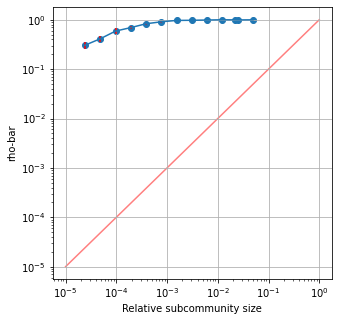

In [116]:
plt.figure(figsize=(5,5))
plt.loglog()
plt.errorbar(x=mini_rel_subcomm_sizes_sorted, y=mean_rho_bar_sorted, yerr = std_rho_bar_sorted, ecolor='red')
plt.scatter(x=mini_rel_subcomm_sizes_sorted, y=mean_rho_bar_sorted)
plt.xlabel('Relative subcommunity size')
plt.ylabel('rho-bar')
plt.plot([0.00001,1], [0.00001,1], zorder=-1000, c="red", alpha=0.5)
plt.grid()
plt.show()

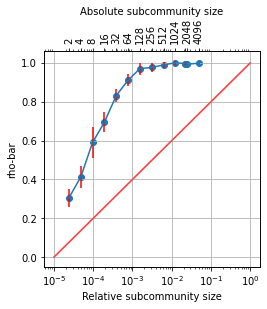

In [117]:
fig = plt.figure(figsize=(3,3))

a1 = fig.add_axes([0,0,1,1])
a1.set_xscale('log')
a1.scatter(x=mini_rel_subcomm_sizes_sorted, y=mean_rho_bar_sorted)
a1.set_xlabel('Relative subcommunity size')
a1.set_ylabel('rho-bar')
a1.plot([0.00001,1], [0.00001,1], zorder=-1000, c="red", alpha=0.5)
a1.grid()

a2 = a1.twiny()
a2.set_xscale('log')
a2.errorbar(x=mini_rel_subcomm_sizes_sorted, y=mean_rho_bar_sorted, yerr = std_rho_bar_sorted, ecolor='red')
a2.set_xticks(mini_rel_subcomm_sizes_sorted, mini_abs_subcomm_sizes_sorted_simplified, rotation='vertical', fontsize=10)
a2.set_xlabel('Absolute subcommunity size')
a2.plot([0.00001,1], [0.00001,1], zorder=-1000, c="red", alpha=0.5)

plt.show()

/var/folders/28/cyrygc490j9g02n4k8ncygzm0000gn/T/ipykernel_15373/2583388446.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(x=x, y=y, yerr=E, ecolor="black", capsize=3, color="black", fmt="ko", ls=":", lw=0.5)


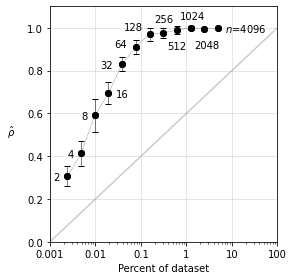

In [359]:
# Ramy's version
fig = plt.figure(figsize=(4.2, 4))

# a1 = fig.add_axes([0,0,1,1])
# a2 = a1.twiny()
x_offsets = [ 2,     2,     2,     0.7,   3,     3,     3.7,  1.6,   1.6,   1.7,   1.7,    0.7 ]
y_offsets = [-0.02, -0.02, -0.02, -0.02, -0.02, -0.0,  0.02,  0.05, -0.09,  0.04, -0.09,  -0.02]
#            2       4      8      16     32     64     128    256   512    1024   2048    4096 

ixs = np.r_[0:10, 11:13]
x   = np.array(mini_rel_subcomm_sizes_sorted)[ixs]
y   = np.array(mean_rho_bar_sorted)[ixs]
s   = np.array(mini_abs_subcomm_sizes_sorted_simplified)[ixs]

mini_abs_subcomm_sizes_sorted = 2**np.arange(1, len(mean_rho_bar_sorted)+1)/n

E = np.array(std_rho_bar_sorted)[ixs]

# data
plt.scatter(x=x, y=y, c="black")
for x_i, y_i, s_i, x_offset, y_offset in zip(x, y, s, x_offsets, y_offsets):
    if s_i == "4096": 
        plt.text(x_i/x_offset, y_i+y_offset, f"$n$={s_i}", c="black")
    else: 
        plt.text(x_i/x_offset, y_i+y_offset, s_i, c="black")
# a1.errorbar(x=mini_abs_subcomm_sizes_sorted[ixs][:-1], y=y[:-1], yerr=E[:-1], ecolor="black", capsize=3, 
#             color="black", fmt="ko", ls=":", lw=0.5)
plt.errorbar(x=x, y=y, yerr=E, ecolor="black", capsize=3, color="black", fmt="ko", ls=":", lw=0.5)

# y=x line
plt.plot([0.00001,1], [0.00001,1], zorder=-1000, c="#999", alpha=0.5)

# cosmetics
plt.xscale('log')
plt.grid(zorder=-1000, lw=0.5, color="#999", alpha=0.5)
plt.xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], [0.001, 0.01, 0.1, 1, 10, 100])
plt.xlabel(r'Percent of dataset')
plt.ylabel(r'$\hat{\rho}$', rotation="horizontal")
ax = plt.gca()
ax.yaxis.set_label_coords(-0.17, .43)
plt.ylim(0, 1.1)
plt.xlim(1e-5, 1e0)
plt.tight_layout()

plt.savefig(outdir + "pathology_fig8c.pdf")
plt.show()

In [342]:
# Find that n=512 is the smallest sample size that contains ≥95% of the diversity of the full dataset
print("256: ", y[7] - 2*E[7])
print("512: ", y[8] - 2*E[8])
print("1024:", y[9] - 2*E[9])

256:  0.927499836109917
512:  0.9540890441900591
1024: 0.9812173436195597


In [346]:
# p-value
z = NormalDist(mu=y[8], sigma=E[8]).zscore(0.95)
norm.sf(z)

0.9871809288331821

# 100 pairs

In [122]:
#Open a file for reading using 'with' statement
with open(indir + 'Phucs_notebooks/hundred_pairs.txt') as hundred_pairs:

    #Read file line by line and store in a list
    list_of_hundred_pairs = hundred_pairs.readlines()

#Check the file is closed or not
if hundred_pairs.closed :
    print("\nThe file is closed.")


The file is closed.


In [123]:
hundred_pairs = []

for i in range(100):
    first = int(list_of_hundred_pairs[i].split(',')[0].split('[')[1].strip()[:-1])
    second = int(list_of_hundred_pairs[i].split(',')[1].split(']')[0].strip()[:-1])
    hundred_pairs.append((first, second))

In [124]:
similarities_of_hundred_pairs = []

for i in range(100):
    first, second = hundred_pairs[i]
    
    sim = sim_func_modified(Xs[first], Xs[second])
    similarities_of_hundred_pairs.append(sim)

In [126]:
#Open a file for reading using 'with' statement
with open(indir + 'Phucs_notebooks/Lizas_reply.txt') as Lizas_reply:

    #Read file line by line and store in a list
    Lizas_data_raw = Lizas_reply.readlines()

#Check the file is closed or not
if Lizas_reply.closed :
    print("\nThe file is closed.")


The file is closed.


In [128]:
#Open a file for reading using 'with' statement
with open(indir + 'Phucs_notebooks/Ramys_reply.txt') as Ramys_reply:

    #Read file line by line and store in a list
    Ramys_data_raw = Ramys_reply.readlines()

#Check the file is closed or not
if Ramys_reply.closed :
    print("\nThe file is closed.")


The file is closed.


In [129]:
Lizas_data = [int(Lizas_data_raw[i][-2:-1]) if Lizas_data_raw[i][-1]=='\n' else int(Lizas_data_raw[i][-1])  for i in range(100)]
Lizas_data = [sim/10 for sim in Lizas_data]

In [130]:
Ramys_data = [0.1] + [float(Ramys_data_raw[i].split(' ')[1][:-1]) for i in range(1,99)] + [0.4]

In [131]:
Counter(Lizas_data)

Counter({0.0: 75,
         0.1: 11,
         0.3: 3,
         0.2: 3,
         0.4: 1,
         0.7: 2,
         0.9: 1,
         0.8: 3,
         0.5: 1})

In [132]:
Counter(Ramys_data)

Counter({0.1: 20, 0.0: 60, 0.5: 3, 0.2: 12, 0.8: 3, 0.9: 1, 0.4: 1})

In [133]:
rsquared_Liza = linregress(Lizas_data, similarities_of_hundred_pairs).rvalue**2

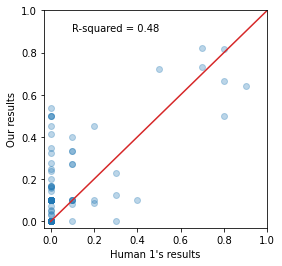

In [350]:
plt.figure(figsize=(4,4))
plt.scatter(Lizas_data, similarities_of_hundred_pairs, alpha=0.3)
plt.xlabel('Human 1\'s results')
plt.ylabel('Our results')
plt.xlim(-0.03, 1)
plt.ylim(-0.03, 1)
plt.plot((0, 1), (0, 1), c="tab:red")
plt.annotate("R-squared = {:.2f}".format(rsquared_Liza), (0.1, 0.9))
plt.show()

In [135]:
rsquared_Ramy = linregress(Ramys_data, similarities_of_hundred_pairs).rvalue**2

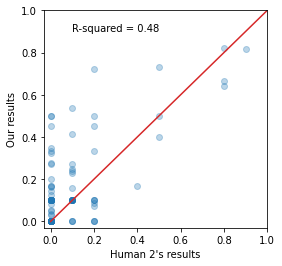

In [349]:
plt.figure(figsize=(4,4))
plt.scatter(Ramys_data, similarities_of_hundred_pairs, alpha=0.3)
plt.xlabel('Human 2\'s results')
plt.ylabel('Our results')
plt.xlim(-0.03, 1)
plt.ylim(-0.03, 1)
plt.plot((0, 1), (0, 1), c="tab:red")
plt.annotate("R-squared = {:.2f}".format(rsquared_Ramy), (0.1, 0.9))
plt.show()

In [137]:
rsquared_Liza_and_Ramy = linregress(Lizas_data, Ramys_data).rvalue**2

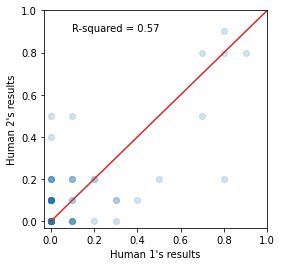

In [348]:
plt.figure(figsize=(4,4))
plt.scatter(Lizas_data, Ramys_data, alpha=0.2)
plt.xlabel('Human 1\'s results')
plt.ylabel('Human 2\'s results')
plt.xlim(-0.03, 1)
plt.ylim(-0.03, 1)
plt.plot((0, 1), (0, 1), c="tab:red")
plt.annotate("R-squared = {:.2f}".format(rsquared_Liza_and_Ramy), (0.1, 0.9))
plt.show()

## Examples of highly similar and highly different pairs

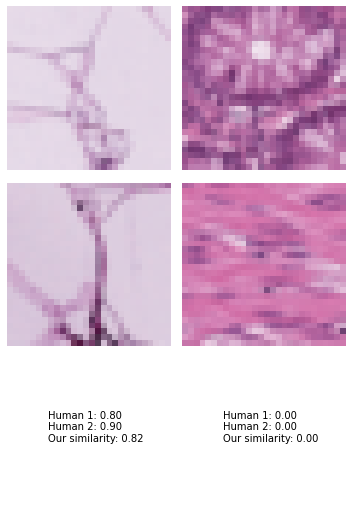

In [331]:
fig, ax = plt.subplots(3, 2, figsize=(5,7.5))

ax[0][0].imshow(shuffled_imgs[hundred_pairs[69][0]])
ax[1][0].imshow(shuffled_imgs[hundred_pairs[69][1]])
ax[2][0].text(0.25,0.5, f"Human 1: {Lizas_data[69]:.2f}\nHuman 2: {Ramys_data[69]:.2f}\nOur similarity: {sim_func_modified(Xs[hundred_pairs[69][0]],Xs[hundred_pairs[69][1]]):.2f}")
ax[0][0].axis('off')
ax[1][0].axis('off')
ax[2][0].axis('off')

ax[0][1].imshow(shuffled_imgs[hundred_pairs[53][0]])
ax[1][1].imshow(shuffled_imgs[hundred_pairs[53][1]])
ax[2][1].text(0.25,0.5, f"Human 1: {Lizas_data[53]:.2f}\nHuman 2: {Ramys_data[53]:.2f}\nOur similarity: {sim_func_modified(Xs[hundred_pairs[53][0]],Xs[hundred_pairs[53][1]]):.2f}")
ax[0][1].axis('off')
ax[1][1].axis('off')
ax[2][1].axis('off')

plt.tight_layout()
plt.savefig(outdir + "pathology_fig8b.pdf")
plt.show()

## Saving representative figures

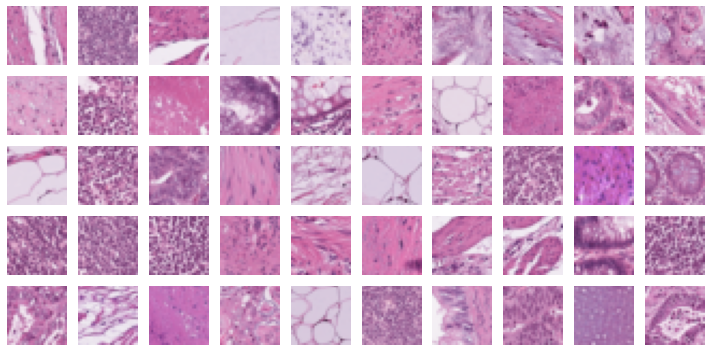

In [337]:
#Visualize the shuffled images. 
fig, axs = plt.subplots(ncols=10, nrows=5, figsize=(10,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[i])
    axs[0][i].axis('off')
for i in range(10):
    axs[1][i].imshow(shuffled_imgs[10+i])
    axs[1][i].axis('off')
for i in range(10):
    axs[2][i].imshow(shuffled_imgs[20+i])
    axs[2][i].axis('off')
for i in range(10):
    axs[3][i].imshow(shuffled_imgs[30+i])
    axs[3][i].axis('off')
for i in range(10):
    axs[4][i].imshow(shuffled_imgs[40+i])
    axs[4][i].axis('off')
plt.tight_layout()
plt.savefig(outdir + "pathology_fig8a.pdf")
plt.show()